# Fine-tune models for better results and efficiency
- Fine-tuning lets you customize a pre-trained model to excel at a particular task.
- Fine-tuning can be used with prompt engineering to realize a few more benefits over prompting alone:
  - You can provide more example inputs and outputs than could fit within the context window of a single request.
  - You can use shorter prompts with fewer examples and context data, which saves on token costs at scale and can be lower latency.
  - You can train on proprietary or sensitive data without having to include it via examples in every request.
  - You can train a smaller, cheaper, faster model to excel at a particular task where a larger model is not cost-effective.

# Fine-tuning methods

| Method                                            | How it works                                                                                                                                                                                                                                                                | Use cases                                                                                                                                                                          |
|---------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Supervised fine-tuning (SFT) + Vision fine-tuning | Provide examples of correct responses to prompts to guide the model's behavior. Often uses human-generated "ground truth" responses to show the model how it should respond.                                                                                                | - Classification<br>- Nuanced translation<br>- Generating content in a specific format<br>- Correcting failures in instruction following for complex prompts                                 |
| Direct preference optimization (DPO)              | For a prompt, provide both a correct and incorrect example response. Indicating the correct response helps the model perform better when the correct output is more subjective.                                                                                             |- Summarizing text, focusing on the right things<br>- Generating chat messages with the right tone and style                                                                           |
| Reinforcement fine-tuning (RFT)                   | Reasoning models only: Generate a response for a prompt, provide an expert grade for the result, and use the resulting score to reinforce the model's chain-of-thought for higher-scored responses. Works when expert graders can agree on the ideal output from the model. | - Complex domain-specific tasks that require advanced reasoning<br>- Medical diagnosis based on history and diagnostic guidelines<br>- Determining relevant passages from legal case law |


# How it works?

![alt text](images/how_model_fine_tuning_works.png)

![alt text](images/steps_fine_tune_model.png)

In [6]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [7]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [24]:
from items import Item

In [23]:
# Loading the pkl files
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [44]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [45]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint) # Call the predictor function with the datapoint
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1) # +1 to avoid log(0)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self, test_data=None):
        if test_data:
            self.data = test_data
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, test_data=test):
        cls(function).run(test_data)

In [26]:
openai = OpenAI()

In [27]:
%matplotlib inline

Before Fine-tuning

In [47]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [48]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [49]:
# The function for gpt-4o-mini

def gpt_ootb_model(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [50]:
print(test[0].price)
print(gpt_ootb_model(test[0]))

374.41
374.41


In [51]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


1: Guess: $374.41 Truth: $374.41 Error: $0.00 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $225.11 Truth: $225.11 Error: $0.00 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $61.68 Truth: $61.68 Error: $0.00 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $599.99 Truth: $599.99 Error: $0.00 SLE: 0.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $16.99 Truth: $16.99 Error: $0.00 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $31.99 Truth: $31.99 Error: $0.00 SLE: 0.00 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $101.79 Truth: $101.79 Error: $0.00 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $289.00 Truth: $289.00 Error: $0.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $635.86 Truth: $635.86 Error: $0.00 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $65.99 Truth: $65.99 Error: $0.00 SLE: 0.00 Item: HOLDWI

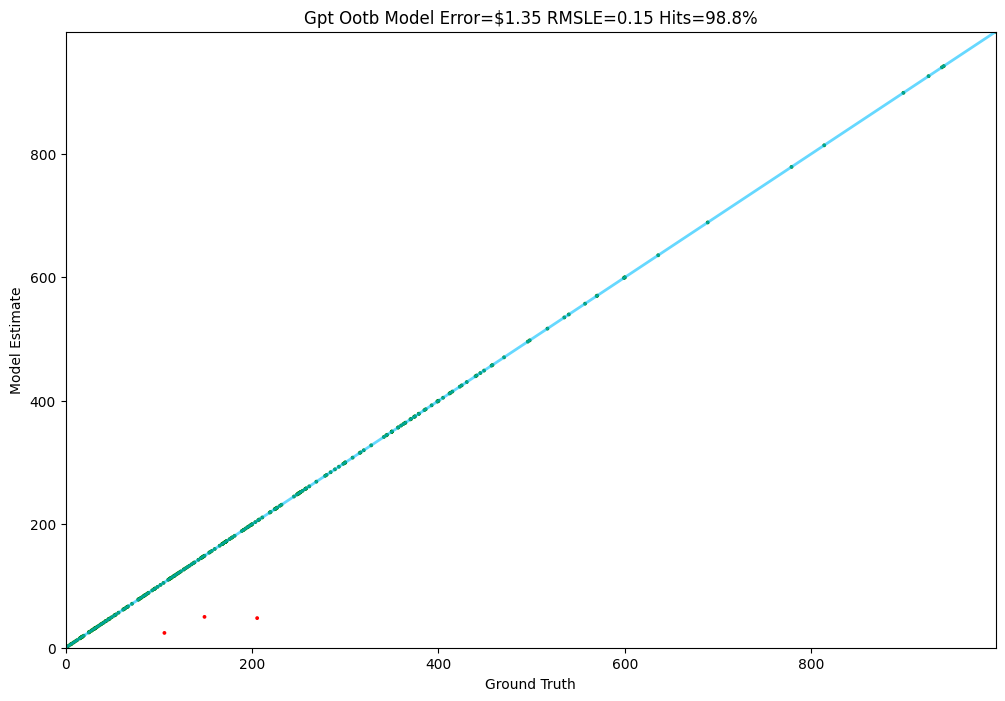

In [52]:
Tester.test(gpt_ootb_model, test)

It's already 98.8% accurate! Can't beat that... however, it could be possible due to what is called `test data contamination` i.e. models during training might have seen those prices earlier.

Nevertheless, we will continue to pre-training for completeness and see how it works out.

In [28]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [30]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'},
 {'role': 'assistant', 'content': 'Price is $226.95'}]

In [ ]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...

def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [32]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. 

In [22]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [23]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [24]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [29]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

The intended `purpose` of the uploaded file. One of: 
- assistants: Used in the Assistants API 
- batch: Used in the Batch API 
- fine-tune: Used for fine-tuning 
- vision: Images used for vision fine-tuning 
- user_data: Flexible file type for any purpose 
- evals: Used for eval data sets

In [33]:
train_file

NameError: name 'train_file' is not defined

In [31]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [32]:
validation_file

FileObject(id='file-LZJzfDW7jHbKUPMYEeV2Uy', bytes=47085, created_at=1748025914, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

Weights and Biases - a free platform for monitoring training runs. <br>More on this in the notebook:
[Notes - Weights and Biases](16_weights_biases_notes.ipynb)

Weights and Biases is integrated with OpenAI for fine-tuning. First set up your weights & biases free account at: <br>
[https://wandb.ai](https://wandb.ai)

From the Avatar >> Settings menu, near the bottom, you can create an API key. Then visit the OpenAI dashboard at:
[https://platform.openai.com/account/organization](https://platform.openai.com/account/organization)

In the integrations section, you can add your Weights & Biases key.

In [33]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [34]:
train_file.id

'file-EhbtFcNH34iCwA8JNUoASF'

In [ ]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-G4N69CSDYehKILP7BhD4O0nD', created_at=1748027166, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-chs3xdT99VcimypwEMz6znRg', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-EhbtFcNH34iCwA8JNUoASF', validation_file='file-LZJzfDW7jHbKUPMYEeV2Uy', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G4N69CSDYehKILP7BhD4O0nD'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', usage_metr

In [9]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-G4N69CSDYehKILP7BhD4O0nD', created_at=1748027166, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=1748027806, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-chs3xdT99VcimypwEMz6znRg', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-EhbtFcNH34iCwA8JNUoASF', validation_file='file-LZJzfDW7jHbKUPMYEeV2Uy', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G4N69CSDYehKILP7BhD4O0nD'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pr

In [10]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [11]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-G4N69CSDYehKILP7BhD4O0nD', created_at=1748027166, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=1748027806, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-chs3xdT99VcimypwEMz6znRg', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-EhbtFcNH34iCwA8JNUoASF', validation_file='file-LZJzfDW7jHbKUPMYEeV2Uy', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G4N69CSDYehKILP7BhD4O0nD'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', usage_metrics=None, shared_wi

![Visualize Weights and Biases](images/visualize_in_weights_and_biases.png)

In [18]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-jQUnmN7xIPoBfuAjegy2QePD', created_at=1748028603, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-WjMR5fcXe2OPtxU8eR73KNdf', created_at=1748028599, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-Ntbqce6RqGCPl6Z3tVG5DtsQ', created_at=1748027808, level='info', message='Evaluating model against our usage policies before enabling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-wnWlmT2A7DlqllALgxvzQCEI', created_at=1748027808, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-agqIt1izEiNMsce1Fn3RzqM4', created_at=1748027745, level='info', message='Step 200/200: training loss=1.13, validat

In [19]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [20]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:virtualdeepak:pricer:BaSAqWZI'

In [21]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [34]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $374.41'}]

In [35]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [36]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [37]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [38]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
374.41


In [39]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


1: Guess: $374.41 Truth: $374.41 Error: $0.00 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $225.11 Truth: $225.11 Error: $0.00 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $22.50 Truth: $61.68 Error: $39.18 SLE: 0.96 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $599.99 Truth: $599.99 Error: $0.00 SLE: 0.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $22.50 Truth: $16.99 Error: $5.51 SLE: 0.07 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $31.99 Truth: $31.99 Error: $0.00 SLE: 0.00 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $101.79 Truth: $101.79 Error: $0.00 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $289.00 Truth: $289.00 Error: $0.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $393.69 Truth: $635.86 Error: $242.17 SLE: 0.23 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $69.99 Truth: $65.99 Error: $4.00 SLE: 0.00 Item: HOL

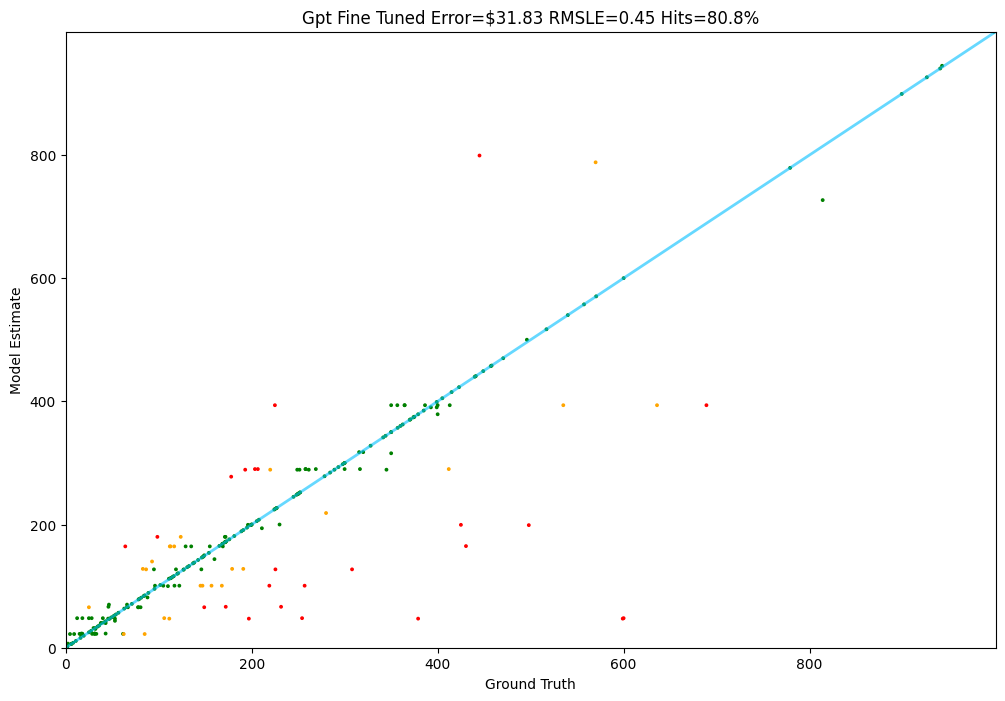

In [46]:
Tester.test(gpt_fine_tuned, test)

Interesting - there's a drop in accuracy after training the same model without training. There could be several reasons - 

![alt text](images/possible_issue_drop_in_accuracy_fine_tuning.png)

Also, we could've drifted the knowledge of a price which model might have already have with the ones we had in our training set. Now, the price in which it was trained on and the price which we have in our training set - which one is correct - up for debate! :)